## Import & Process Image

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import glob

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

In [2]:
model = VGG16(include_top=False, input_shape=(100, 100, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [3]:
model.layers

In [4]:
model.layers[:-2]

## EDA

In [2]:
# Import converted images
X = np.load('data/100x100.npy')
y = np.load('data/diagnosis.npy')

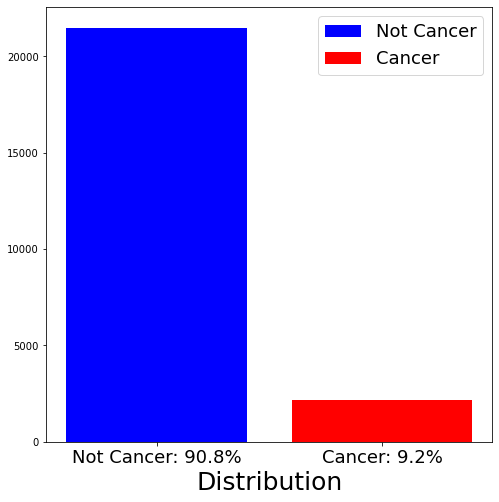

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
xlabel = 25
xtick = 18
x0 = (y==0).sum()
x1 = (y==1).sum()

ax.set_xlabel('Distribution', size=xlabel)

ax.bar(0, x0, color = 'b', label='Not Cancer')
ax.bar(1, x1, color = 'r', label='Cancer')
ax.set_xticks([0,1])
ax.set_xticklabels(['Not Cancer: 90.8%', 'Cancer: 9.2%'], size=xtick)
plt.legend(prop={'size': 18})
fig.show()

## Train Test Split for Train, validation, test set

In [3]:
# Train/test split for Train Set
XX_train, X_test, yy_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(XX_train, yy_train, test_size=0.2, random_state=42, stratify=yy_train)

## Pipeline

In [54]:
# Calculate imbalance data
ones = (y_train==1).sum()
zeros = (y_train==0).sum()
adj_ones = zeros/(ones+zeros)
adj_zero = ones/(ones+zeros)

print('Adjusted Zeros Ratio: {}'.format(adj_ones))
print('Adjusted Ones  Ratio: {}'.format(adj_zero))

class_weight = {1:adj_ones,
                0:adj_zero}

Adjusted Zeros Ratio: 0.9083702186694854
Adjusted Ones  Ratio: 0.09162978133051464


In [8]:
## Import Model
model = VGG16(include_top=False, input_shape=(100, 100, 3))

## Transfer Learning
new_model = Sequential()
for layer in model.layers[:-2]: # just exclude the last two FC layers
    layer.trainable = False
    new_model.add(layer)
new_model.add(Conv2D(512, (5, 5), activation = 'relu', padding = 'same'))
new_model.add(MaxPooling2D(2,2))
new_model.add(Flatten())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1, activation ='sigmoid'))

In [9]:
opt = keras.optimizers.SGD(learning_rate=0.002)
new_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
# tf.keras.metrics.Recall()

In [10]:
history = new_model.fit(X_train, y_train, epochs=20, batch_size=32, class_weight=class_weight, validation_data=(X_test, y_test))

Epoch 1/20
474/474 [==============================] - 560s 1s/step - loss: 0.0839 - accuracy: 0.7107 - val_loss: 0.4316 - val_accuracy: 0.7656
Epoch 2/20
474/474 [==============================] - 559s 1s/step - loss: 0.0722 - accuracy: 0.7547 - val_loss: 0.4162 - val_accuracy: 0.7730
Epoch 3/20
474/474 [==============================] - 556s 1s/step - loss: 0.0694 - accuracy: 0.7612 - val_loss: 0.4692 - val_accuracy: 0.7415
Epoch 4/20
474/474 [==============================] - 556s 1s/step - loss: 0.0681 - accuracy: 0.7630 - val_loss: 0.4730 - val_accuracy: 0.7383
Epoch 5/20
474/474 [==============================] - 556s 1s/step - loss: 0.0666 - accuracy: 0.7653 - val_loss: 0.4103 - val_accuracy: 0.7740
Epoch 6/20
474/474 [==============================] - 556s 1s/step - loss: 0.0656 - accuracy: 0.7693 - val_loss: 0.4531 - val_accuracy: 0.7480
Epoch 7/20
474/474 [==============================] - 555s 1s/step - loss: 0.0648 - accuracy: 0.7686 - val_loss: 0.3721 - val_accuracy: 0.7975

In [24]:
from src.functions import plot_accuracy, plot_loss, plot_recall
import pickle

In [25]:
# Saving the epoch history
with open('models/trainHistoryDict_hamid20', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

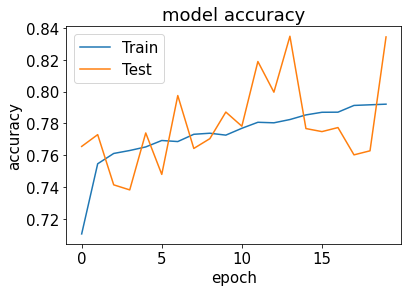

In [29]:
plot_accuracy(history)

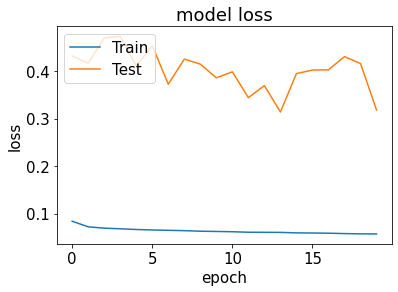

In [20]:
plot_loss(history)

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
# Use if you need to plot recall.
# plot_recall(history, 'recall')

#### Saving Model

In [26]:
new_model.save('models/vgg_transfer_hamid_20epochs_v2.h5')

#### Importing Model

In [4]:
new_model = load_model('models/vgg_transfer_hamid_20epochs_v2.h5')

## Evaluation

### ROC AUC

In [5]:
# Predictions for Validation Set
y_val_pred = new_model.predict(X_val)

In [6]:
# Predictions for Test Set
y_test_pred = new_model.predict(X_test)

In [8]:
fpr, tpr, thres_roc = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr, tpr)

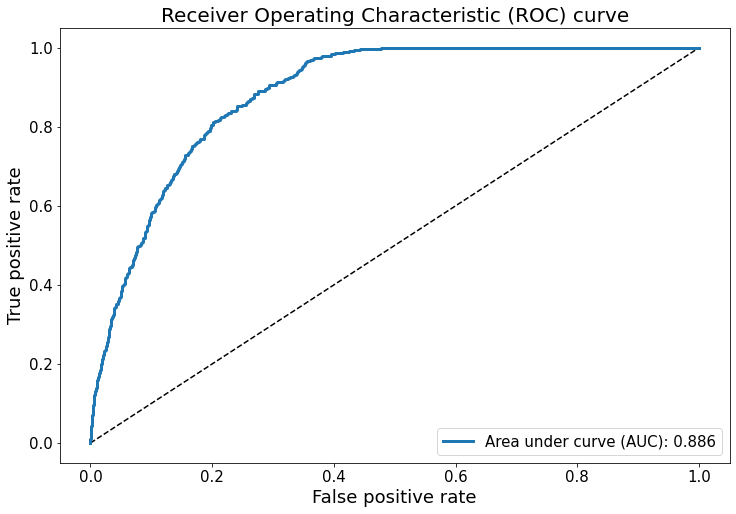

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
ticks = np.arange(-0.2 ,1.2 , 0.2)

title_size = 20
label_size = 18
legend_size = 15
tick_size = 15

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, label='Area under curve (AUC): {:.3f}'.format(auc_keras), linewidth=3.0)

ax.set_title('Receiver Operating Characteristic (ROC) curve', size=title_size)

ax.set_xlabel('False positive rate', size=label_size)
ax.set_ylabel('True positive rate', size=label_size)

ax.set_xticklabels(ticks, fontsize=tick_size)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_yticklabels(ticks, fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.legend(loc='best', fontsize=legend_size)
fig.show()
# fig.savefig('img/roc_auc.png')

### Precision Recall Curve

In [11]:
precision, recall, thresh_pr_curve = precision_recall_curve(y_test, y_test_pred)
thresh_loc = len(recall[recall>=0.95])

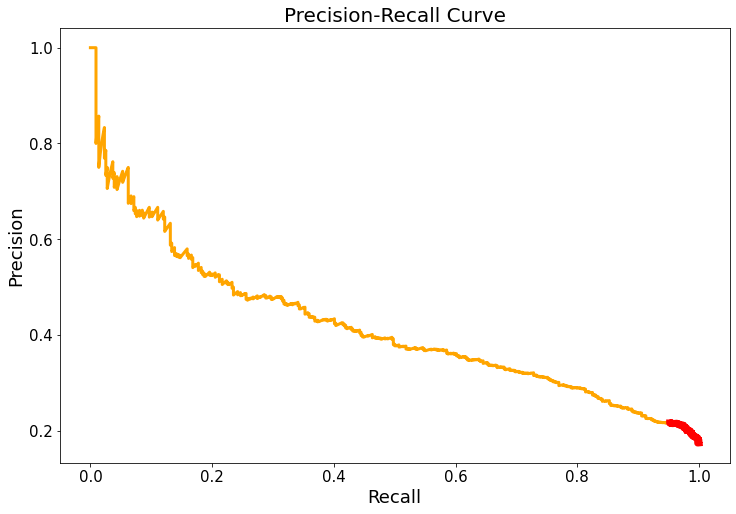

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ticks = np.arange(-0.2 ,1.2 , 0.2)

title_size = 20
label_size = 18
legend_size = 15
tick_size = 15

ax.plot(recall, precision, color='orange', linewidth=3.0)
ax.plot(recall[:thresh_loc], precision[:thresh_loc], marker='*', color='red', linewidth=7.0)

ax.set_title('Precision-Recall Curve', size=title_size)

ax.set_xticklabels(ticks, fontsize=tick_size)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_yticklabels(ticks, fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel('Recall', size=label_size)
ax.set_ylabel('Precision', size=label_size)

fig.show()
# fig.savefig('img/pr_curve.png')

In [14]:
# The most liberal threshold given that recall >= 95%
liberal_thresh = thresh_pr_curve[:thresh_loc][-1]
liberal_thresh

0.17948207

In [15]:
# F1 scores for all thresholds
f1_all = [f1_score(y_test, y_test_pred >= i) for i in thresh_pr_curve]
# F1 scores when recall >= 95%
f1_lst = [f1_score(y_test, y_test_pred >= i) for i in thresh_pr_curve[:thresh_loc]]
# Index of highest F1 score when recall >= 95%
max_index_col = np.argmax(f1_lst, axis=0)

In [42]:
plt.rcParams.update({'font.size': 13})

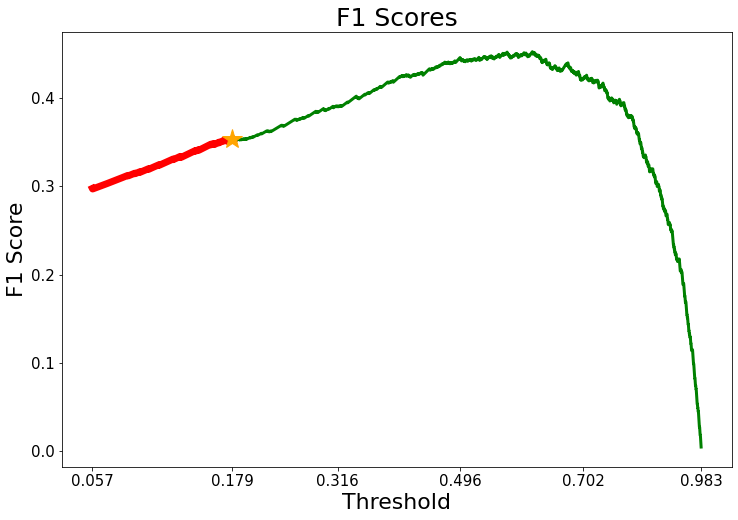

In [52]:
fig, ax = plt.subplots(figsize=(12,8))

xticks = [0.057, 0.179, 0.316, 0.496, 0.702, 0.983]
yticks = [0.0,0.1,0.2,0.3,0.4]
f1_x = np.arange(len(f1_lst))
f1_xx = np.arange(len(f1_all))

title_size = 25
label_size = 22
legend_size = 15
tick_size = 15

ax.plot(f1_xx, f1_all, color='green', linewidth=3.0)
ax.plot(f1_x, f1_lst, color='red', linewidth=7.0)

ax.plot(f1_xx[max_index_col], f1_all[max_index_col], 
        marker='*', markersize=20, color='orange')

ax.set_title('F1 Scores', size=title_size)

ax.set_xticks([0,571,1000,1500,2000,2482])
ax.set_yticks([0.0,0.1,0.2,0.3,0.4])
ax.set_xticklabels(xticks, fontsize=tick_size)
ax.set_yticklabels(yticks, fontsize=tick_size)

ax.set_xlabel('Threshold', size=label_size)
ax.set_ylabel('F1 Score', size=label_size)

fig.show()
# fig.savefig('img/f1.png')

In [18]:
# The highest F1 score threshold given that recall >= 95%.
final_thresh = thresh_pr_curve[max_index_col]
final_thresh

0.17885771

### Confusion Matrix

In [20]:
from src.functions import matrix_score

#### Base Model (Random choice based on probability)

In [55]:
y_base = np.random.choice(2, len(y_test), p=[adj_ones,adj_zero])
matrix_score(y_test, y_base)

[[  36  398]
 [ 382 3915]]
Recall:    0.083
Precision: 0.086
Accuracy:  0.835
ROC AUC:   0.497


In [56]:
f1_score(y_test, y_base)

0.08450704225352113

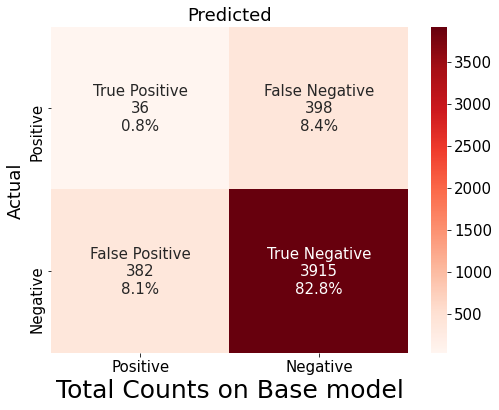

In [58]:
plt.rcParams.update({'font.size': 15})
title=25
tick = 14
label= 18

class_labels = ['Positive', 'Negative']
cm = confusion_matrix(y_test, y_base, normalize=None)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
cm = np.array([[tp, fn], [fp, tn]])

group_names = ['True Positive','False Negative','False Positive','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm,cmap='Reds', annot=labels, fmt='', ax=ax,xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Predicted', size=label)
ax.set_xlabel('Total Counts on Base model', size=title)
ax.set_ylabel('Actual', size=label)
fig.show()
# fig.savefig('img/base_model_cm.png');

#### Validation Set

In [21]:
matrix_score(y_val, y_val_pred >= final_thresh)

[[ 333   14]
 [1130 2308]]
Recall:    0.960
Precision: 0.228
Accuracy:  0.698
ROC AUC:   0.815


In [22]:
f1_score(y_val, y_val_pred>=final_thresh)

0.3679558011049724

#### Test Set

In [23]:
matrix_score(y_test, y_test_pred >= final_thresh)

[[ 414   20]
 [1498 2799]]
Recall:    0.954
Precision: 0.217
Accuracy:  0.679
ROC AUC:   0.803


In [24]:
f1_score(y_test, y_test_pred>=final_thresh)

0.35294117647058826

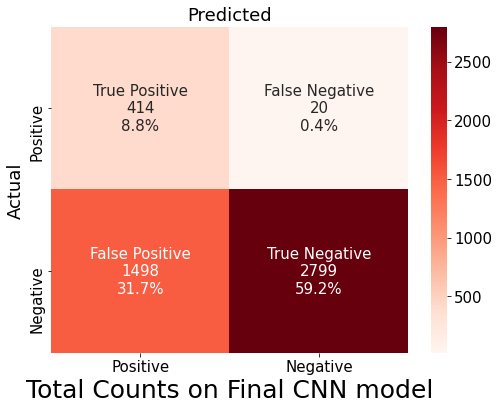

In [26]:
plt.rcParams.update({'font.size': 15})
title=25
tick = 14
label= 18

class_labels = ['Positive', 'Negative']
cm = confusion_matrix(y_test,(y_test_pred >= final_thresh).astype(int),normalize=None)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
cm = np.array([[tp, fn], [fp, tn]])

group_names = ['True Positive','False Negative','False Positive','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm,cmap='Reds', annot=labels, fmt='', ax=ax,xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Predicted', size=label)
ax.set_xlabel('Total Counts on Final CNN model', size=title)
ax.set_ylabel('Actual', size=label)
fig.show()
# fig.savefig('img/final_CNN.png');